In [1]:
%pip install tqdm

In [57]:
def top_cumulative_preds(softmax_outputs, threshold=0.95):
    selected_labels = []
    for output in softmax_outputs:
        # Flatten the output tensor and get values and indices
        sorted_probs, sorted_indices = torch.sort(output.flatten(), descending=True)

        cumulative_sum = 0.0
        current_image_labels = []
        for prob, index in zip(sorted_probs, sorted_indices):
            cumulative_sum += prob.item()
            current_image_labels.append(index.item())
            if cumulative_sum >= threshold:
                break
        selected_labels.append(tuple(current_image_labels))
    return selected_labels


Now, let's apply this function to your `softmax_preds` with a threshold of 0.95 to get the top cumulative predictions.

In [58]:
top_95_cumulative_preds = top_cumulative_preds(softmax_preds, threshold=0.95)

print("First 5 images' top 95% cumulative predictions:")
for i, preds in enumerate(top_95_cumulative_preds[:5]):
    print(f"Image {i}: {preds}")


First 5 images' top 95% cumulative predictions:
Image 0: (8, 0, 3, 4, 7, 9, 2, 6)
Image 1: (4, 9, 0, 7, 3, 2, 8, 1, 5)
Image 2: (4, 9, 3, 2, 6, 8, 5, 7)
Image 3: (4, 8, 0, 9, 2, 6, 7, 5)
Image 4: (8, 0, 2, 9, 4, 7, 3, 5)


In [2]:
%matplotlib inline

import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import ToPILImage
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

In [3]:
#Converts a tensor image to the proper numpy format of (x, y, channels) from a format of (channels, x, y).
def im_transform(tensor):
    if tensor.shape[0]==3 or tensor.shape[0]==1:
      return tensor.permute(1,2,0).numpy()
    else:
      print('It seems this image is already formatted properly for numpy operations.')

#The concatenating image function for combining four images with four labels into a single grid-like image.
#For this the indices of images and the dataset they are from must be defined. It is optional to pull out
#The corresponding labels or to resize to other dimensions.
def concat_image(indices,dataset,labels=False,resizing=None):
    cc_img=np.zeros((64,64,3))
    cats=[]
    for i in range(4):
        temp_img=im_transform(dataset[indices[i]][0])
        cats.append(dataset[indices[i]][1])
        if i == 0:
            cc_img[0:32,0:32]=temp_img
        elif i == 1:
            cc_img[0:32,32:64]=temp_img
        elif i == 2:
            cc_img[32:64,0:32]=temp_img
        else:
            cc_img[32:64,32:64]=temp_img
    if resizing:
        from skimage.transform import resize
        try:
            cc_img=resize(cc_img,resizing)
        except:
            print('Make sure the resizing input is given as a tuple of the desired dimensions')
    if labels:
        return cc_img,tuple(cats)
    else:
        return cc_img

#Converts an image stored as a numpy array back to the proper format for saving the image through the PIL package.
def revert_np_image(im_array):
  tmp=ToTensor()(im_array)
  return ToPILImage()(tmp)

In [4]:
#This function generates random integers to use as indices for pulling images from the original database for concatenation.
#Inputs here are i_max, which is the total number of images in the original database,
#and iterations, which is the number of new images one plans to generate.
def rand_indices(i_max,iterations):
    from random import randint
    i_max=i_max-1
    indices=[]
    for i in range(iterations):
        i1=randint(0,i_max)
        i2=randint(0,i_max)
        while i2 == i1:
            i2=randint(0,i_max)
        i3=randint(0,i_max)
        while i3 == i2 or i3 == i1:
            i3=randint(0,i_max)
        i4=randint(0,i_max)
        while i4 == i3 or i4 == i2 or i4 == i1:
            i4=randint(0,i_max)
        indices.append(tuple([i1,i2,i3,i4]))
    return indices


#This function simply creates a new destination folder to dump the concatenated images.
#By default, this function will create a folder in the current directory unless otherwise specified.
def set_directories(directory=None):
  if not directory:
    directory='/temp_dir/'
  if directory[0]!='/':
    return print('Make sure you have a new folder properly formatted with a \"/\" at the beginning')
  else:
    import os
    cd=os.getcwd()
    target=cd+directory
    if not os.path.exists(target):
      os.makedirs(target)
    return target

#This function initializes a dataframe formatted to track the original indices
#that are randomized to specific concatenation of the original  pulled, their respective labels,
#and the new filenames saved within the new database.
def create_dataframe(num_entries,base_data):
  import pandas as pd
  import numpy as np
  dataframe=pd.DataFrame()
  dataframe['Indices']=rand_indices(len(base_data),num_entries)
  dataframe['Label_1']=np.zeros(num_entries,dtype=object)
  dataframe['Label_2']=np.zeros(num_entries,dtype=object)
  dataframe['Label_3']=np.zeros(num_entries,dtype=object)
  dataframe['Label_4']=np.zeros(num_entries,dtype=object)
  dataframe['Filename']=np.zeros(num_entries,dtype=object)
  return dataframe

#This function generates the entire database through the use of the prior functions.
#Only the size of the data base through num_entries and the original dataset need to be provided,
#and everything else will be initialized to a default value. It's recommended to input the image_dest
#and df_name as specific file destinations/final table name if generating multiple datasets.
def generate_data(num_entries,base_data,image_dest=None,resizing=None,dataframe=None,df_name=None):
  import os
  if not image_dest:
    image_dest=set_directories()
  else:
    image_dest=set_directories(image_dest)
  if not resizing:
    resizing=(32,32)
  if not dataframe:
    dataframe=create_dataframe(num_entries,base_data)
  if not df_name:
    df_name='concated_data.csv'

  from tqdm import tqdm

  for i in tqdm(range (num_entries),desc='Generating ... '):
    temp_ind=dataframe['Indices'][i]
    temp_im,labels=concat_image(temp_ind,base_data,labels=True,resizing=resizing)
    if num_entries > 100000:
      name=image_dest+f'{i+1:09d}'+'.jpg'
    else:
      name=image_dest+f'{i+1:06d}'+'.jpg'
    revert_np_image(temp_im).save(name)
    dataframe.at[i,'Filename']=name
    dataframe.at[i,'Label_1']=labels[0]
    dataframe.at[i,'Label_2']=labels[1]
    dataframe.at[i,'Label_3']=labels[2]
    dataframe.at[i,'Label_4']=labels[3]
    dataframe.to_csv(os.getcwd()+'/'+df_name)
  print('\nThe data table is saved to '+df_name+', and images are stored within '+image_dest+'.')
  return dataframe

In [5]:
def pic_label_show(image=None,labels=None,dataframe=None,predictions=False):
    if type(image)!=torch.Tensor:
      from PIL import Image
      if not labels:
        try:
          labels=dataframe.loc[dataframe['Filename']==image,'Labels'][1]
        except:
          return print('The image path could not be located. Operation has been aborted.')
      try:
        image=Image.open(image)
        image=ToTensor()(image)
      except:
        return print('The image input is formatted incorrectly. Either load in a tensor corresponding to the image or the correct file path.')
    cat_keys={
     0:'airplane',
    1:'automobile',
    2:'bird',
    3:'cat',
    4:'deer',
    5:'dog',
    6:'frog',
    7:'horse',
    8:'ship',
    9:'truck'
    }
    if image.shape[0]==3 or image.shape[0]==1:
      image=im_transform(image)
    x=image.shape[0]
    y=image.shape[1]
    fig, ax = plt.subplots()
    if len(labels)==1:
      label=cat_keys[labels]
      try:
        ax.imshow(image)
      except:
        return print("The image format may have been incorrect. Please make sure it is in the numpy image format of (x, y, channels)")
      plt.text(2,2,label,bbox=dict(facecolor='white'))
    else:
        if len(labels) % 4 != 0:
                print('Image does not appear square with four distinct quadrants.')
        elif not predictions:
          cats=[cat_keys[label] for label in labels]
          try:
            ax.imshow(image)
          except:
            return print("The image format may have been incorrect. Please make sure it is in the numpy image format of (x, y, channels)")
        for i in range(len(cats)):
          if i == 0:
            plt.text(2,2,cats[i],bbox=dict(facecolor='white'))
          elif i == 1:
            plt.text(2+int(x/2),2,cats[i],bbox=dict(facecolor='white'))
          elif i == 2:
            plt.text(2,2+int(y/2),cats[i],bbox=dict(facecolor='white'))
          else:
            plt.text(2+int(x/2),2+int(y/2),cats[i],bbox=dict(facecolor='white'))
    return None

In [6]:
# This cell code changed from FashionMNIST to CIFAR10

# Download training data from open datasets.
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)


100%|██████████| 170M/170M [00:03<00:00, 54.3MB/s]


In [7]:

size_database=500
concat_data=generate_data(size_database,test_data,image_dest='/test/',df_name='test.csv')

Generating ... : 100%|██████████| 500/500 [00:07<00:00, 67.74it/s]


The data table is saved to test.csv, and images are stored within /content/test/.


In [8]:
####above code adds test/test.csv to directory for ease of access when using colab

##Zip and upload utils from https://github.com/SHI-Labs/Compact-Transformers/tree/main/src



In [9]:
%pip install timm

In [10]:
%pip install ipynb

In [11]:
%pip install kneed

In [12]:
%pip install torch torchvision torchaudio

In [13]:
!unzip utils.zip

Archive:  utils.zip
   creating: utils/
  inflating: __MACOSX/._utils        
  inflating: utils/transformers.py   
  inflating: __MACOSX/utils/._transformers.py  
 extracting: utils/__init__.py       
  inflating: __MACOSX/utils/.___init__.py  
  inflating: utils/tokenizer.py      
  inflating: __MACOSX/utils/._tokenizer.py  
  inflating: utils/embedder.py       
  inflating: __MACOSX/utils/._embedder.py  
  inflating: utils/stochastic_depth.py  
  inflating: __MACOSX/utils/._stochastic_depth.py  
  inflating: utils/helpers.py        
  inflating: __MACOSX/utils/._helpers.py  


In [14]:
%matplotlib inline

# Original Code from the SHI-Labs
# .utils in the from lines changed to utils
# .registry import changed to the function def (copied from the registry.py)

import torch
from torch.hub import load_state_dict_from_url
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from utils.transformers import TransformerClassifier
from utils.tokenizer import Tokenizer
from utils.helpers import pe_check, fc_check
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os
import kneed



In [15]:
try:
    from timm.models.registry import register_model
except ImportError:
    #from .registry import register_model
    def register_model(func):
      """
      Fallback wrapper in case timm isn't installed
      """
      return func

model_urls = {
    'cct_7_3x1_32':
        'https://shi-labs.com/projects/cct/checkpoints/pretrained/cct_7_3x1_32_cifar10_300epochs.pth'
}


class CCT(nn.Module):
    def __init__(self,
                 img_size=224,
                 embedding_dim=768,
                 n_input_channels=3,
                 n_conv_layers=1,
                 kernel_size=7,
                 stride=2,
                 padding=3,
                 pooling_kernel_size=3,
                 pooling_stride=2,
                 pooling_padding=1,
                 dropout=0.,
                 attention_dropout=0.1,
                 stochastic_depth=0.1,
                 num_layers=14,
                 num_heads=6,
                 mlp_ratio=4.0,
                 num_classes=1000,
                 positional_embedding='learnable',
                 *args, **kwargs):
        super(CCT, self).__init__()

        self.tokenizer = Tokenizer(n_input_channels=n_input_channels,
                                   n_output_channels=embedding_dim,
                                   kernel_size=kernel_size,
                                   stride=stride,
                                   padding=padding,
                                   pooling_kernel_size=pooling_kernel_size,
                                   pooling_stride=pooling_stride,
                                   pooling_padding=pooling_padding,
                                   max_pool=True,
                                   activation=nn.ReLU,
                                   n_conv_layers=n_conv_layers,
                                   conv_bias=False)

        self.classifier = TransformerClassifier(
            sequence_length=self.tokenizer.sequence_length(n_channels=n_input_channels,
                                                           height=img_size,
                                                           width=img_size),
            embedding_dim=embedding_dim,
            seq_pool=True,
            dropout=dropout,
            attention_dropout=attention_dropout,
            stochastic_depth=stochastic_depth,
            num_layers=num_layers,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio,
            num_classes=num_classes,
            positional_embedding=positional_embedding
        )

    def forward(self, x):
        x = self.tokenizer(x)
        return self.classifier(x)


def _cct(arch, pretrained, progress,
         num_layers, num_heads, mlp_ratio, embedding_dim,
         kernel_size=3, stride=None, padding=None,
         positional_embedding='learnable',
         *args, **kwargs):
    stride = stride if stride is not None else max(1, (kernel_size // 2) - 1)
    padding = padding if padding is not None else max(1, (kernel_size // 2))
    model = CCT(num_layers=num_layers,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                embedding_dim=embedding_dim,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                *args, **kwargs)

    if pretrained:
        if arch in model_urls:
            state_dict = load_state_dict_from_url(model_urls[arch],
                                                  progress=progress)
            if positional_embedding == 'learnable':
                state_dict = pe_check(model, state_dict)
            elif positional_embedding == 'sine':
                state_dict['classifier.positional_emb'] = model.state_dict()['classifier.positional_emb']
            state_dict = fc_check(model, state_dict)
            model.load_state_dict(state_dict)
        else:
            raise RuntimeError(f'Variant {arch} does not yet have pretrained weights.')
    return model

def cct_7(arch, pretrained, progress, *args, **kwargs):
    return _cct(arch, pretrained, progress, num_layers=7, num_heads=4, mlp_ratio=2, embedding_dim=256,
                *args, **kwargs)
@register_model
def cct_7_3x1_32(pretrained=False, progress=False,
                 img_size=32, positional_embedding='learnable', num_classes=10,
                 *args, **kwargs):
    return cct_7('cct_7_3x1_32', pretrained, progress,
                 kernel_size=3, n_conv_layers=1,
                 img_size=img_size, positional_embedding=positional_embedding,
                 num_classes=num_classes,
                 *args, **kwargs)




/usr/local/lib/python3.12/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


# New Section

##Modified the Workflow from the Quickstart Tutorial of PyTorch


[Learn the Basics](intro.html) ||
**Quickstart** ||
[Tensors](tensorqs_tutorial.html) ||
[Datasets & DataLoaders](data_tutorial.html) ||
[Transforms](transforms_tutorial.html) ||
[Build Model](buildmodel_tutorial.html) ||
[Autograd](autogradqs_tutorial.html) ||
[Optimization](optimization_tutorial.html) ||
[Save & Load Model](saveloadrun_tutorial.html)

# Quickstart
This section runs through the API for common tasks in machine learning. Refer to the links in each section to dive deeper.

## Working with data
PyTorch has two [primitives to work with data](https://pytorch.org/docs/stable/data.html):
``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset``.


PyTorch offers domain-specific libraries such as [TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and [TorchAudio](https://pytorch.org/audio/stable/index.html),
all of which include datasets. For this tutorial, we  will be using a TorchVision dataset.

The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like
CIFAR, COCO ([full list here](https://pytorch.org/vision/stable/datasets.html)). In this tutorial, we
use the FashionMNIST dataset. Every TorchVision ``Dataset`` includes two arguments: ``transform`` and
``target_transform`` to modify the samples and labels respectively.



We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
in the dataloader iterable will return a batch of 64 features and labels.



In [16]:
def im_transform(tensor):
    if tensor.shape[0]==3 or tensor.shape[0]==1:
      return tensor.permute(1,2,0).numpy()
    else:
      print('It seems this image is already formatted properly for numpy operations.')

def pic_label_show(image=None,labels=None,dataframe=None,predictions=False,save=False,file_dest=None):
    if type(image)!=torch.Tensor:
      if not labels:
        try:
          labels=dataframe.loc[dataframe['Filename']==image,'Labels'][1]
        except:
          return print('The image path could not be located. Operation has been aborted.')
      try:
        image=Image.open(image)
        image=ToTensor()(image)
      except:
        return print('The image input is formatted incorrectly. Either load in a tensor corresponding to the image or the correct file path.')
    cat_keys={
    0:'airplane',
    1:'automobile',
    2:'bird',
    3:'cat',
    4:'deer',
    5:'dog',
    6:'frog',
    7:'horse',
    8:'ship',
    9:'truck'
    }
    if image.shape[0]==3 or image.shape[0]==1:
      image=im_transform(image)
    x=image.shape[0]
    y=image.shape[1]
    fig, ax = plt.subplots()
    if len(labels)==1:
      label=cat_keys[labels]
      try:
        ax.imshow(image)
      except:
        return print("The image format may have been incorrect. Please make sure it is in the numpy image format of (x, y, channels)")
      plt.text(2,2,label,bbox=dict(facecolor='white'))
    else:
      if len(labels) % 4 != 0:
        return print('Image does not appear square with four distinct quadrants.')
      else:
        cats=[cat_keys[label] for label in labels]
      try:
        ax.imshow(image)
      except:
        return print("The image format may have been incorrect. Please make sure it is in the numpy image format of (x, y, channels)")
      if not predictions:
        for i in range(len(cats)):
          if i == 0:
            plt.text(2,2,cats[i],bbox=dict(facecolor='white'))
          elif i == 1:
            plt.text(2+int(x/2),2,cats[i],bbox=dict(facecolor='white'))
          elif i == 2:
            plt.text(2,2+int(y/2),cats[i],bbox=dict(facecolor='white'))
          else:
              plt.text(2+int(x/2),2+int(y/2),cats[i],bbox=dict(facecolor='white'))
      else:
        plt.text(0,1,'Possible matches of '+str(cats),bbox=dict(facecolor='white'))
    if save & isinstance(file_dest, str):
      fig.savefig(os.getcwd()+'/'+file_dest+'.png')
    return None


In [17]:
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]


## Load a model and Predict on a single input

In [18]:
import torch
import os
from utils.helpers import pe_check, fc_check # Ensure these are imported from your utils directory

# Define the local path to your downloaded model weights
local_model_path = '/content/cct_7_3x1_32_cifar10_300epochs.pth'

# Check if the file exists
if not os.path.exists(local_model_path):
    print(f"Error: Model file not found at {local_model_path}. Please upload the file first.")
else:
    # Instantiate the model without loading pretrained weights initially
    # The parameters should match how the model was defined in cct_7_3x1_32
    model = CCT(num_layers=7, num_heads=4, mlp_ratio=2, embedding_dim=256,
                kernel_size=3, n_conv_layers=1,
                img_size=32, positional_embedding='learnable',
                num_classes=10)

    # Load the state dictionary from the local file
    state_dict = torch.load(local_model_path, map_location=torch.device('cpu'))

    # Apply checks similar to the original _cct function
    # pe_check handles positional embeddings
    if 'learnable' == 'learnable': # Assuming positional_embedding is 'learnable' as in the original call
        state_dict = pe_check(model, state_dict)
    # fc_check handles the final classification layer
    state_dict = fc_check(model, state_dict)

    # Load the processed state dictionary into the model
    model.load_state_dict(state_dict)
    print("Model loaded successfully from local file!")

Model loaded successfully from local file!


In [19]:
import torch
import os
from utils.helpers import pe_check, fc_check # Ensure these are imported from your utils directory

# Define the local path to your downloaded model weights
local_model_path = '/content/cct_7_3x1_32_cifar10_300epochs.pth'

# Check if the file exists
if not os.path.exists(local_model_path):
    print(f"Error: Model file not found at {local_model_path}. Please upload the file first.")
else:
    # Instantiate the model without loading pretrained weights initially
    # The parameters should match how the model was defined in cct_7_3x1_32
    model = CCT(num_layers=7, num_heads=4, mlp_ratio=2, embedding_dim=256,
                kernel_size=3, n_conv_layers=1,
                img_size=32, positional_embedding='learnable',
                num_classes=10)

    # Load the state dictionary from the local file
    state_dict = torch.load(local_model_path, map_location=torch.device('cpu'))

    # Apply checks similar to the original _cct function
    # pe_check handles positional embeddings
    if 'learnable' == 'learnable': # Assuming positional_embedding is 'learnable' as in the original call
        state_dict = pe_check(model, state_dict)
    # fc_check handles the final classification layer
    state_dict = fc_check(model, state_dict)

    # Load the processed state dictionary into the model
    model.load_state_dict(state_dict)
    print("Model loaded successfully from local file!")

Model loaded successfully from local file!


In [20]:
print(model)

CCT(
  (tokenizer): Tokenizer(
    (conv_layers): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
        (1): ReLU()
        (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
    )
    (flattener): Flatten(start_dim=2, end_dim=3)
  )
  (classifier): TransformerClassifier(
    (attention_pool): Linear(in_features=256, out_features=1, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): TransformerEncoderLayer(
        (pre_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attn): Attention(
          (qkv): Linear(in_features=256, out_features=768, bias=False)
          (attn_drop): Dropout(p=0.1, inplace=False)
          (proj): Linear(in_features=256, out_features=256, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=

In [21]:
print(model)

CCT(
  (tokenizer): Tokenizer(
    (conv_layers): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
        (1): ReLU()
        (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
    )
    (flattener): Flatten(start_dim=2, end_dim=3)
  )
  (classifier): TransformerClassifier(
    (attention_pool): Linear(in_features=256, out_features=1, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): TransformerEncoderLayer(
        (pre_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attn): Attention(
          (qkv): Linear(in_features=256, out_features=768, bias=False)
          (attn_drop): Dropout(p=0.1, inplace=False)
          (proj): Linear(in_features=256, out_features=256, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=

In [22]:
def top4_preds(pred):
    list_convert=list(pred[0])
    num_list=[]
    for i in range(len(list_convert)):
        num_list.append(float(list_convert[i]))
    top4=[]
    for i in range(4):
        top4.append(num_list.index(max(num_list)))
        num_list[top4[i]]=-10
    return tuple(top4)

def image_to_pred(file,model):
    im=ToTensor()(Image.open(file))
    with torch.no_grad():
        im=im[None,:]
        pred=model(im)
    return pred

def labels_extract(db,col_names=None):
    if not col_names:
        col_names=['Label_1','Label_2','Label_3','Label_4']
    for i in range(len(col_names)):
        try:
            db[col_names[i]]
        except:
            print('The input database is not formatted correctly to extract labels')
    labels=[]
    for i in range(len(db.index)):
        temp=[]
        for j in range(len(col_names)):
            temp.append(db[col_names[j]][i])
        labels.append(tuple(temp))
    return labels

def images_and_labels(db,label_cols=None,file_col=None):
    if not label_cols:
        label_cols=['Label_1','Label_2','Label_3','Label_4']
    if not file_col:
        file_col='Filename'
    try:
        db[file_col]
    except:
        print('Make sure to input the correct column name for the image file paths.')
    for i in range(len(label_cols)):
        try:
            db[label_cols[i]]
        except:
            print('The input database is not formatted correctly to extract labels')

    files=list(mo_data[file_col])
    labels=labels_extract(db,label_cols)
    return files,labels

def acc_table(labels,predicted,col_names=None):
    if not col_names:
        col_names=['Actuals','Predictions','Num_matches']
    elif len(col_names) != 3:
        return print('This function only creates a table with 3 columns. Make sure only labels for 3 columns are included')
    acc_eval=pd.DataFrame()
    acc_eval[col_names[0]]=labels
    acc_eval[col_names[1]]=predicted
    tot_corr=[]
    for i in range(len(predicted)):
        num_corr=0
        for j in range(len(predicted[i])):
            if predicted[i][j] in labels[i]:
                num_corr+=1
        tot_corr.append(num_corr)
    acc_eval[col_names[2]]=tot_corr
    return acc_eval

def plot_correct_total(tot_corr,db,max_matches=4,match_col='Num_matches',x_title=None,y_title=None,plt_title=None,save=False,file_dest=None):
    num_preds=len(tot_corr)
    if not x_title:
        x_title='Correct matches for given prediction'
    if not y_title:
        y_title='Total number of correct matches'
    if not plt_title:
        plt_title='Distribution of correct matches for '+str(num_preds)+' multi-object predictions'
    fig,ax = plt.subplots()
    corr_cats=list(range(max_matches+1))
    counts=[]
    for i in corr_cats:
        counts.append(sum(db[match_col]==i))
    ax=plt.bar(corr_cats,counts)
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.title(plt_title)
    plt.ylim(ymin=0,ymax=num_preds)
    for rect in ax:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')
    if save & isinstance(file_dest, str):
        fig.savefig(os.getcwd()+'/'+file_dest+'.png')

def plot_correct_prop(tot_corr,db,max_matches=4,match_col='Num_matches',x_title=None,y_title=None,plt_title=None,save=False,file_dest=None):
    num_preds=len(tot_corr)
    if not x_title:
        x_title='Correct matches for given prediction'
    if not y_title:
        y_title='Proportional number of correct matches (%)'
    if not plt_title:
        plt_title='Distribution of correct matches for '+str(num_preds)+' multi-object predictions'
    fig,ax = plt.subplots()
    corr_cats=list(range(max_matches+1))
    counts=[]
    for i in corr_cats:
        counts.append(sum(db[match_col]==i))
    prop_counts = [x / num_preds *100 for x in counts]
    ax=plt.bar(corr_cats,prop_counts)
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.title(plt_title)
    plt.ylim(ymin=0,ymax=100)
    for rect in ax:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f} %', ha='center', va='bottom')
    if save & isinstance(file_dest, str):
        fig.savefig(os.getcwd()+'/'+file_dest+'.png')




In [23]:
def gen_knees(preds,shape=None):
    if shape is None:
        shapes=[]
        for i in range(len(preds)):
            x=range(1,len(preds[i])+1)
            tmp=np.polyfit(x,preds[i],2)
            if tmp[0]<0:
                shapes.append('concave')
            else:
                shapes.append('convex')
    knee_val=[]
    for i in range(len(preds)):
        x=range(1,len(preds[i])+1)
        if shape is not None:
            kneedle=kneed.KneeLocator(x,preds[i],curve=shape,direction='decreasing')
        else:
            kneedle=kneed.KneeLocator(x,preds[i],curve=shapes[i],direction='decreasing')
        knee_val.append(kneedle.knee)
    for i in range(len(knee_val)):
        if knee_val[i] is None:
            knee_val[i]=1
    return knee_val

def plot_knees(preds,knee_val=None,shape=None,x_title=None,y_title=None,plt_title=None,assumption=None,save=False,file_dest=None):
    if not knee_val:
        if not shape:
            knee_val=gen_knees(preds)
        else:
            knee_val=gen_knees(preds,shape=shape)
    num_preds=len(preds)
    if not x_title:
        x_title='# of classes'
    if not y_title:
        y_title='Count of knee values per # of classes'
    if not plt_title:
        plt_title='Distribution of knee values for '+str(num_preds)+' multi-object predictions'
    fig,ax = plt.subplots()
    x=range(1,len(preds[0])+1)
    counts=list(np.zeros(len(preds[0])))
    for i in range(len(knee_val)):
        counts[knee_val[i]-1]+=1
    ax=plt.bar(x,counts)
    plt.xticks(range(1,len(counts)+1))
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.title(plt_title)
    plt.ylim(ymin=0,ymax=1.25*max(counts))
    if not shape:
        plt.annotate('Individually assessed convexity vs concavity',xy=(0.05,0.95),xycoords='axes fraction')
    else:
        plt.annotate('Assumption of all softmax outputs having '+shape+' shapes.',xy=(0.05,0.95),xycoords='axes fraction')
    for rect in ax:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')
    if save & isinstance(file_dest, str):
        fig.savefig(os.getcwd()+'/'+file_dest+'.png')


In [24]:
#for a better understanding of the data and how it is structured read that file as this file mainly deals with the CCT
mo_data=pd.read_csv(os.getcwd()+'/test.csv')

In [25]:
mo_data.shape

(500, 7)

In [26]:
files,labels=images_and_labels(mo_data)

In [27]:
from tqdm import tqdm

predicted=[]
for i in tqdm(range(len(files)), 'Predicting... '):
    predicted.append(image_to_pred(files[i],model))

Predicting... : 100%|██████████| 500/500 [00:23<00:00, 21.13it/s]


## Top 95% predictions

In [28]:
top_4_preds=[]
for i in range(len(predicted)):
    top_4_preds.append(top4_preds(predicted[i]))

In [29]:
#using .softmax() function to convert ouptputs into probabilities of classification
m = nn.Softmax(dim=1)
softmax_preds=[]
for i in range(len(predicted)):
    softmax_preds.append(m(predicted[i]))

In [30]:
#fills the list N_arr with all the false labels probability amount (populates no cat images)
N_arr=[]
amount=0
#filling false positive arr
for i in range(500):
    for j in range(10):
        if j in labels[i]:
            pass
            #donothing
        else:
            N_arr.append(softmax_preds[i][0][j].item())


In [31]:
P_arr=[]
#fills the list P_arr with all the true labels probability amount (populates cat images)
for i in range(500):
    for j in range(4):
        correct_label_index = labels[i][j]
        P_arr.append(softmax_preds[i][0][correct_label_index].item())


In [32]:
def num_corr(labels,predicted):
    tot_corr=[]
    for i in range(len(predicted)):
        num_corr=0
        for j in range(len(predicted[i])):
            if predicted[i][j] in labels[i]:
                num_corr+=1
        tot_corr.append(num_corr)
    return tot_corr

def total_num_of_pred(labels,predicted):
    tot_corr=[]
    total_num_of_corr = 0
    for i in range(len(predicted)):
        num_corr=0
        for j in range(len(predicted[i])):
            if predicted[i][j] in labels[i]:
                num_corr+=1
        tot_corr.append(num_corr)
        total_num_of_corr += num_corr
    return total_num_of_corr

Top 95% Code

In [60]:
total=total_num_of_pred(labels,top_95_cumulative_preds)
corr_per_file = num_corr(labels,top_95_cumulative_preds)
len(top_95_cumulative_preds)


500

In [64]:
def acc_table(labels,predicted,col_names=None):
    if not col_names:
        col_names=['Actuals','Predictions','Num_matches','Prediction_Count'] # Added 'Prediction_Count'
    elif len(col_names) != 4: # Updated expected number of columns
        return print('This function only creates a table with 4 columns. Make sure only labels for 4 columns are included')
    acc_eval=pd.DataFrame()
    acc_eval[col_names[0]]=labels
    acc_eval[col_names[1]]=predicted
    tot_corr=[]
    pred_counts = [] # New list for prediction counts
    for i in range(len(predicted)):
        num_corr=0
        for j in range(len(predicted[i])):
            if predicted[i][j] in labels[i]:
                num_corr+=1
        tot_corr.append(num_corr)
        pred_counts.append(len(predicted[i])) # Store the count of predictions
    acc_eval[col_names[2]]=tot_corr
    acc_eval[col_names[3]]=pred_counts # Add Prediction_Count column
    return acc_eval

acc_eval=acc_table(labels,top_95_cumulative_preds)


In [35]:
labels_as_int = []
for img_labels in labels:
    labels_as_int.append(tuple(int(label) for label in img_labels))

labels = labels_as_int
print("Labels converted to standard Python integers.")
print(labels[0])

Labels converted to standard Python integers.
(3, 2, 7, 9)


In [63]:
comparison_df = pd.DataFrame({
    'Image Number': range(len(labels)),
    'Correct Labels': labels,
    'Top 95% Cumulative Predicted Labels': top_95_cumulative_preds
})

display(comparison_df.to_string())


'     Image Number Correct Labels Top 95% Cumulative Predicted Labels\n0               0   (3, 2, 7, 9)            (8, 0, 3, 4, 7, 9, 2, 6)\n1               1   (8, 9, 5, 0)         (4, 9, 0, 7, 3, 2, 8, 1, 5)\n2               2   (2, 7, 2, 7)            (4, 9, 3, 2, 6, 8, 5, 7)\n3               3   (0, 6, 6, 7)            (4, 8, 0, 9, 2, 6, 7, 5)\n4               4   (9, 8, 4, 0)            (8, 0, 2, 9, 4, 7, 3, 5)\n5               5   (3, 9, 0, 9)         (2, 9, 8, 4, 1, 6, 0, 3, 5)\n6               6   (9, 5, 1, 4)            (9, 5, 8, 3, 4, 6, 2, 1)\n7               7   (3, 0, 6, 4)            (4, 8, 0, 3, 2, 9, 1, 6)\n8               8   (8, 0, 7, 4)            (0, 8, 2, 4, 9, 6, 3, 5)\n9               9   (5, 9, 9, 9)         (8, 4, 9, 0, 2, 5, 3, 7, 6)\n10             10   (6, 5, 8, 9)         (4, 0, 8, 9, 6, 7, 1, 2, 5)\n11             11   (8, 9, 2, 8)               (4, 8, 0, 7, 5, 9, 3)\n12             12   (7, 5, 5, 2)         (2, 4, 3, 5, 6, 9, 7, 0, 1)\n13             13  

In [37]:
acc_eval

,Actuals,Predictions,Num_matches
0,"(3, 2, 7, 9)","(8, 0, 3, 4)",1
1,"(8, 9, 5, 0)","(4, 9, 0, 7)",2
2,"(2, 7, 2, 7)","(4, 9, 3, 2)",1
3,"(0, 6, 6, 7)","(4, 8, 0, 9)",1
4,"(9, 8, 4, 0)","(8, 0, 2, 9)",3
...,...,...,...
495,"(2, 7, 3, 4)","(4, 3, 7, 8)",3
496,"(3, 4, 8, 9)","(0, 8, 4, 5)",2
497,"(0, 7, 6, 1)","(0, 8, 2, 4)",1
498,"(8, 5, 5, 1)","(5, 8, 6, 3)",2


In [38]:
acc_eval.head()

,Actuals,Predictions,Num_matches
0,"(3, 2, 7, 9)","(8, 0, 3, 4)",1
1,"(8, 9, 5, 0)","(4, 9, 0, 7)",2
2,"(2, 7, 2, 7)","(4, 9, 3, 2)",1
3,"(0, 6, 6, 7)","(4, 8, 0, 9)",1
4,"(9, 8, 4, 0)","(8, 0, 2, 9)",3


In [76]:
#Export Results to an Excel Spreadsheet
acc_eval.to_excel("acc_eval.xlsx", index=False, sheet_name="Results")

In [77]:
top_68_cumulative_preds = top_cumulative_preds(softmax_preds, threshold=0.68)

print("First 5 images' top 68% cumulative predictions:")
for i, preds in enumerate(top_68_cumulative_preds[:5]):
    print(f"Image {i}: {preds}")


First 5 images' top 68% cumulative predictions:
Image 0: (8, 0, 3)
Image 1: (4, 9, 0, 7)
Image 2: (4, 9, 3)
Image 3: (4, 8)
Image 4: (8, 0, 2, 9)


Now, let's update the accuracy evaluation and metrics for the top 68% cumulative predictions.

In [78]:
total_68 = total_num_of_pred(labels, top_68_cumulative_preds)
corr_per_file_68 = num_corr(labels, top_68_cumulative_preds)
print(f"Total images evaluated: {len(top_68_cumulative_preds)}")


Total images evaluated: 500


In [79]:
acc_eval_68 = acc_table(labels, top_68_cumulative_preds)


In [80]:
# 1) Multiset (duplicates matter) TP/FP/FN + P/R/F1 for 68% threshold
per_img_rows_68, multiset_summary_68 = per_image_tp_fp_fn_multiset(labels, top_68_cumulative_preds)
print("Multiset summary (68% threshold):", multiset_summary_68)

# 2A) Presence-based TN / NPV / FOR / Markedness (ignores multiplicity for TN) for 68% threshold
presence_metrics_68 = micro_metrics_presence_with_negatives(labels, top_68_cumulative_preds, num_classes=10)
print("Presence-based FOR/Markedness (68% threshold):", presence_metrics_68)


Multiset summary (68% threshold): {'total_TP': 727, 'micro_precision': 0.42564402810304447, 'micro_recall': 0.3635, 'total_pred_pos': 1708, 'total_true_pos': 2000}
Presence-based FOR/Markedness (68% threshold): {'TP': 727, 'FP': 981, 'FN': 995, 'TN': 2297, 'precision': 0.426, 'recall': 0.422, 'NPV': 0.698, 'FOR': 0.302, 'markedness': 0.124}


In [81]:
comparison_df_68 = pd.DataFrame({
    'Image Number': range(len(labels)),
    'Correct Labels': labels,
    'Top 68% Cumulative Predicted Labels': top_68_cumulative_preds
})

print("Comparison DataFrame for Top 68% Cumulative Predictions:")
display(comparison_df_68.to_string())


Comparison DataFrame for Top 68% Cumulative Predictions:


'     Image Number Correct Labels Top 68% Cumulative Predicted Labels\n0               0   (3, 2, 7, 9)                           (8, 0, 3)\n1               1   (8, 9, 5, 0)                        (4, 9, 0, 7)\n2               2   (2, 7, 2, 7)                           (4, 9, 3)\n3               3   (0, 6, 6, 7)                              (4, 8)\n4               4   (9, 8, 4, 0)                        (8, 0, 2, 9)\n5               5   (3, 9, 0, 9)                        (2, 9, 8, 4)\n6               6   (9, 5, 1, 4)                           (9, 5, 8)\n7               7   (3, 0, 6, 4)                              (4, 8)\n8               8   (8, 0, 7, 4)                              (0, 8)\n9               9   (5, 9, 9, 9)                     (8, 4, 9, 0, 2)\n10             10   (6, 5, 8, 9)                        (4, 0, 8, 9)\n11             11   (8, 9, 2, 8)                              (4, 8)\n12             12   (7, 5, 5, 2)                     (2, 4, 3, 5, 6)\n13             13  

In [82]:
print("Displaying the entire acc_eval DataFrame with Prediction_Count for 68% Threshold:")
display(acc_eval_68.style.format({"Prediction_Count": "{:,.0f}"}))


Displaying the entire acc_eval DataFrame with Prediction_Count for 68% Threshold:


,Actuals,Predictions,Num_matches,Prediction_Count
0,"(3, 2, 7, 9)","(8, 0, 3)",1,3
1,"(8, 9, 5, 0)","(4, 9, 0, 7)",2,4
2,"(2, 7, 2, 7)","(4, 9, 3)",0,3
3,"(0, 6, 6, 7)","(4, 8)",0,2
4,"(9, 8, 4, 0)","(8, 0, 2, 9)",3,4
5,"(3, 9, 0, 9)","(2, 9, 8, 4)",1,4
6,"(9, 5, 1, 4)","(9, 5, 8)",2,3
7,"(3, 0, 6, 4)","(4, 8)",1,2
8,"(8, 0, 7, 4)","(0, 8)",2,2
9,"(5, 9, 9, 9)","(8, 4, 9, 0, 2)",1,5


In [91]:
top_99_7_cumulative_preds = top_cumulative_preds(softmax_preds, threshold=0.997)

print("First 5 images' top 99.7% cumulative predictions:")
for i, preds in enumerate(top_99_7_cumulative_preds[:5]):
    print(f"Image {i}: {preds}")


First 5 images' top 99.7% cumulative predictions:
Image 0: (8, 0, 3, 4, 7, 9, 2, 6, 1, 5)
Image 1: (4, 9, 0, 7, 3, 2, 8, 1, 5, 6)
Image 2: (4, 9, 3, 2, 6, 8, 5, 7, 0, 1)
Image 3: (4, 8, 0, 9, 2, 6, 7, 5, 3, 1)
Image 4: (8, 0, 2, 9, 4, 7, 3, 5, 1, 6)


Now, let's update the accuracy evaluation and metrics for the top 99.7% cumulative predictions.

In [92]:
total_99_7 = total_num_of_pred(labels, top_99_7_cumulative_preds)
corr_per_file_99_7 = num_corr(labels, top_99_7_cumulative_preds)
print(f"Total images evaluated: {len(top_99_7_cumulative_preds)}")


Total images evaluated: 500


In [93]:
acc_eval_99_7 = acc_table(labels, top_99_7_cumulative_preds)


In [94]:
# 1) Multiset (duplicates matter) TP/FP/FN + P/R/F1 for 99.7% threshold
per_img_rows_99_7, multiset_summary_99_7 = per_image_tp_fp_fn_multiset(labels, top_99_7_cumulative_preds)
print("Multiset summary (99.7% threshold):", multiset_summary_99_7)

# 2A) Presence-based TN / NPV / FOR / Markedness (ignores multiplicity for TN) for 99.7% threshold
presence_metrics_99_7 = micro_metrics_presence_with_negatives(labels, top_99_7_cumulative_preds, num_classes=10)
print("Presence-based FOR/Markedness (99.7% threshold):", presence_metrics_99_7)


Multiset summary (99.7% threshold): {'total_TP': 1722, 'micro_precision': 0.3444, 'micro_recall': 0.861, 'total_pred_pos': 5000, 'total_true_pos': 2000}
Presence-based FOR/Markedness (99.7% threshold): {'TP': 1722, 'FP': 3278, 'FN': 0, 'TN': 0, 'precision': 0.344, 'recall': 1.0, 'NPV': 0.0, 'FOR': 1.0, 'markedness': -0.656}


In [95]:
comparison_df_99_7 = pd.DataFrame({
    'Image Number': range(len(labels)),
    'Correct Labels': labels,
    'Top 99.7% Cumulative Predicted Labels': top_99_7_cumulative_preds
})

print("Comparison DataFrame for Top 99.7% Cumulative Predictions:")
display(comparison_df_99_7.to_string())


Comparison DataFrame for Top 99.7% Cumulative Predictions:


'     Image Number Correct Labels Top 99.7% Cumulative Predicted Labels\n0               0   (3, 2, 7, 9)        (8, 0, 3, 4, 7, 9, 2, 6, 1, 5)\n1               1   (8, 9, 5, 0)        (4, 9, 0, 7, 3, 2, 8, 1, 5, 6)\n2               2   (2, 7, 2, 7)        (4, 9, 3, 2, 6, 8, 5, 7, 0, 1)\n3               3   (0, 6, 6, 7)        (4, 8, 0, 9, 2, 6, 7, 5, 3, 1)\n4               4   (9, 8, 4, 0)        (8, 0, 2, 9, 4, 7, 3, 5, 1, 6)\n5               5   (3, 9, 0, 9)        (2, 9, 8, 4, 1, 6, 0, 3, 5, 7)\n6               6   (9, 5, 1, 4)        (9, 5, 8, 3, 4, 6, 2, 1, 7, 0)\n7               7   (3, 0, 6, 4)        (4, 8, 0, 3, 2, 9, 1, 6, 5, 7)\n8               8   (8, 0, 7, 4)        (0, 8, 2, 4, 9, 6, 3, 5, 7, 1)\n9               9   (5, 9, 9, 9)        (8, 4, 9, 0, 2, 5, 3, 7, 6, 1)\n10             10   (6, 5, 8, 9)        (4, 0, 8, 9, 6, 7, 1, 2, 5, 3)\n11             11   (8, 9, 2, 8)        (4, 8, 0, 7, 5, 9, 3, 1, 2, 6)\n12             12   (7, 5, 5, 2)        (2, 4, 3, 5, 6, 9, 7, 0

In [96]:
print("Displaying the entire acc_eval DataFrame with Prediction_Count for 99.7% Threshold:")
display(acc_eval_99_7.style.format({"Prediction_Count": "{:,.0f}"}))


Displaying the entire acc_eval DataFrame with Prediction_Count for 99.7% Threshold:


,Actuals,Predictions,Num_matches,Prediction_Count
0,"(3, 2, 7, 9)","(8, 0, 3, 4, 7, 9, 2, 6, 1, 5)",4,10
1,"(8, 9, 5, 0)","(4, 9, 0, 7, 3, 2, 8, 1, 5, 6)",4,10
2,"(2, 7, 2, 7)","(4, 9, 3, 2, 6, 8, 5, 7, 0, 1)",2,10
3,"(0, 6, 6, 7)","(4, 8, 0, 9, 2, 6, 7, 5, 3, 1)",3,10
4,"(9, 8, 4, 0)","(8, 0, 2, 9, 4, 7, 3, 5, 1, 6)",4,10
5,"(3, 9, 0, 9)","(2, 9, 8, 4, 1, 6, 0, 3, 5, 7)",3,10
6,"(9, 5, 1, 4)","(9, 5, 8, 3, 4, 6, 2, 1, 7, 0)",4,10
7,"(3, 0, 6, 4)","(4, 8, 0, 3, 2, 9, 1, 6, 5, 7)",4,10
8,"(8, 0, 7, 4)","(0, 8, 2, 4, 9, 6, 3, 5, 7, 1)",4,10
9,"(5, 9, 9, 9)","(8, 4, 9, 0, 2, 5, 3, 7, 6, 1)",2,10


In [97]:
acc_eval_99_7.to_excel("acc_eval_99_7.xlsx", index=False, sheet_name="Results_99_7_Percent")
print("acc_eval_99_7.xlsx has been saved successfully.")


acc_eval_99_7.xlsx has been saved successfully.


The `acc_eval_99_7.xlsx` file has been saved to your Colab environment. You can find it in the file browser (folder icon on the left sidebar).

In [84]:
top_90_cumulative_preds = top_cumulative_preds(softmax_preds, threshold=0.90)

print("First 5 images' top 90% cumulative predictions:")
for i, preds in enumerate(top_90_cumulative_preds[:5]):
    print(f"Image {i}: {preds}")


First 5 images' top 90% cumulative predictions:
Image 0: (8, 0, 3, 4, 7, 9, 2)
Image 1: (4, 9, 0, 7, 3, 2, 8, 1)
Image 2: (4, 9, 3, 2, 6, 8, 5)
Image 3: (4, 8, 0, 9, 2, 6)
Image 4: (8, 0, 2, 9, 4, 7, 3)


Now, let's update the accuracy evaluation and metrics for the top 90% cumulative predictions.

In [85]:
total_90 = total_num_of_pred(labels, top_90_cumulative_preds)
corr_per_file_90 = num_corr(labels, top_90_cumulative_preds)
print(f"Total images evaluated: {len(top_90_cumulative_preds)}")


Total images evaluated: 500


In [86]:
acc_eval_90 = acc_table(labels, top_90_cumulative_preds)


In [87]:
# 1) Multiset (duplicates matter) TP/FP/FN + P/R/F1 for 90% threshold
per_img_rows_90, multiset_summary_90 = per_image_tp_fp_fn_multiset(labels, top_90_cumulative_preds)
print("Multiset summary (90% threshold):", multiset_summary_90)

# 2A) Presence-based TN / NPV / FOR / Markedness (ignores multiplicity for TN) for 90% threshold
presence_metrics_90 = micro_metrics_presence_with_negatives(labels, top_90_cumulative_preds, num_classes=10)
print("Presence-based FOR/Markedness (90% threshold):", presence_metrics_90)


Multiset summary (90% threshold): {'total_TP': 1275, 'micro_precision': 0.38345864661654133, 'micro_recall': 0.6375, 'total_pred_pos': 3325, 'total_true_pos': 2000}
Presence-based FOR/Markedness (90% threshold): {'TP': 1275, 'FP': 2050, 'FN': 447, 'TN': 1228, 'precision': 0.383, 'recall': 0.74, 'NPV': 0.733, 'FOR': 0.267, 'markedness': 0.116}


In [88]:
comparison_df_90 = pd.DataFrame({
    'Image Number': range(len(labels)),
    'Correct Labels': labels,
    'Top 90% Cumulative Predicted Labels': top_90_cumulative_preds
})

print("Comparison DataFrame for Top 90% Cumulative Predictions:")
display(comparison_df_90.to_string())


Comparison DataFrame for Top 90% Cumulative Predictions:


'     Image Number Correct Labels Top 90% Cumulative Predicted Labels\n0               0   (3, 2, 7, 9)               (8, 0, 3, 4, 7, 9, 2)\n1               1   (8, 9, 5, 0)            (4, 9, 0, 7, 3, 2, 8, 1)\n2               2   (2, 7, 2, 7)               (4, 9, 3, 2, 6, 8, 5)\n3               3   (0, 6, 6, 7)                  (4, 8, 0, 9, 2, 6)\n4               4   (9, 8, 4, 0)               (8, 0, 2, 9, 4, 7, 3)\n5               5   (3, 9, 0, 9)               (2, 9, 8, 4, 1, 6, 0)\n6               6   (9, 5, 1, 4)                  (9, 5, 8, 3, 4, 6)\n7               7   (3, 0, 6, 4)                     (4, 8, 0, 3, 2)\n8               8   (8, 0, 7, 4)                  (0, 8, 2, 4, 9, 6)\n9               9   (5, 9, 9, 9)            (8, 4, 9, 0, 2, 5, 3, 7)\n10             10   (6, 5, 8, 9)            (4, 0, 8, 9, 6, 7, 1, 2)\n11             11   (8, 9, 2, 8)                     (4, 8, 0, 7, 5)\n12             12   (7, 5, 5, 2)            (2, 4, 3, 5, 6, 9, 7, 0)\n13             13  

In [89]:
print("Displaying the entire acc_eval DataFrame with Prediction_Count for 90% Threshold:")
display(acc_eval_90.style.format({"Prediction_Count": "{:,.0f}"}))


Displaying the entire acc_eval DataFrame with Prediction_Count for 90% Threshold:


,Actuals,Predictions,Num_matches,Prediction_Count
0,"(3, 2, 7, 9)","(8, 0, 3, 4, 7, 9, 2)",4,7
1,"(8, 9, 5, 0)","(4, 9, 0, 7, 3, 2, 8, 1)",3,8
2,"(2, 7, 2, 7)","(4, 9, 3, 2, 6, 8, 5)",1,7
3,"(0, 6, 6, 7)","(4, 8, 0, 9, 2, 6)",2,6
4,"(9, 8, 4, 0)","(8, 0, 2, 9, 4, 7, 3)",4,7
5,"(3, 9, 0, 9)","(2, 9, 8, 4, 1, 6, 0)",2,7
6,"(9, 5, 1, 4)","(9, 5, 8, 3, 4, 6)",3,6
7,"(3, 0, 6, 4)","(4, 8, 0, 3, 2)",3,5
8,"(8, 0, 7, 4)","(0, 8, 2, 4, 9, 6)",3,6
9,"(5, 9, 9, 9)","(8, 4, 9, 0, 2, 5, 3, 7)",2,8


In [90]:
acc_eval_90.to_excel("acc_eval_90.xlsx", index=False, sheet_name="Results_90_Percent")
print("acc_eval_90.xlsx has been saved successfully.")


acc_eval_90.xlsx has been saved successfully.


The `acc_eval_90.xlsx` file has been saved to your Colab environment. You can find it in the file browser (folder icon on the left sidebar).

In [83]:
acc_eval_68.to_excel("acc_eval_68.xlsx", index=False, sheet_name="Results_68_Percent")
print("acc_eval_68.xlsx has been saved successfully.")


acc_eval_68.xlsx has been saved successfully.


The `acc_eval_68.xlsx` file has been saved to your Colab environment. You can find it in the file browser (folder icon on the left sidebar).

In [67]:
print("Displaying the entire acc_eval DataFrame with Prediction_Count:")
display(acc_eval.style.format({"Prediction_Count": "{:,.0f}"})) # or adjust formatting


Displaying the entire acc_eval DataFrame with Prediction_Count:


,Actuals,Predictions,Num_matches,Prediction_Count
0,"(3, 2, 7, 9)","(8, 0, 3, 4, 7, 9, 2, 6)",4,8
1,"(8, 9, 5, 0)","(4, 9, 0, 7, 3, 2, 8, 1, 5)",4,9
2,"(2, 7, 2, 7)","(4, 9, 3, 2, 6, 8, 5, 7)",2,8
3,"(0, 6, 6, 7)","(4, 8, 0, 9, 2, 6, 7, 5)",3,8
4,"(9, 8, 4, 0)","(8, 0, 2, 9, 4, 7, 3, 5)",4,8
5,"(3, 9, 0, 9)","(2, 9, 8, 4, 1, 6, 0, 3, 5)",3,9
6,"(9, 5, 1, 4)","(9, 5, 8, 3, 4, 6, 2, 1)",4,8
7,"(3, 0, 6, 4)","(4, 8, 0, 3, 2, 9, 1, 6)",4,8
8,"(8, 0, 7, 4)","(0, 8, 2, 4, 9, 6, 3, 5)",3,8
9,"(5, 9, 9, 9)","(8, 4, 9, 0, 2, 5, 3, 7, 6)",2,9


(array([ 31.,   0., 180.,   0.,   0., 206.,   0.,  78.,   0.,   5.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

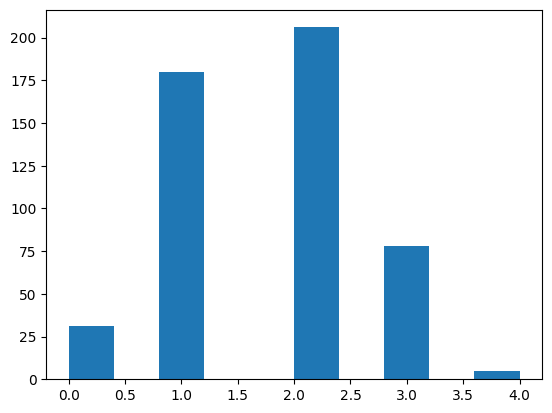

In [43]:
plt.hist(acc_eval['Num_matches'])

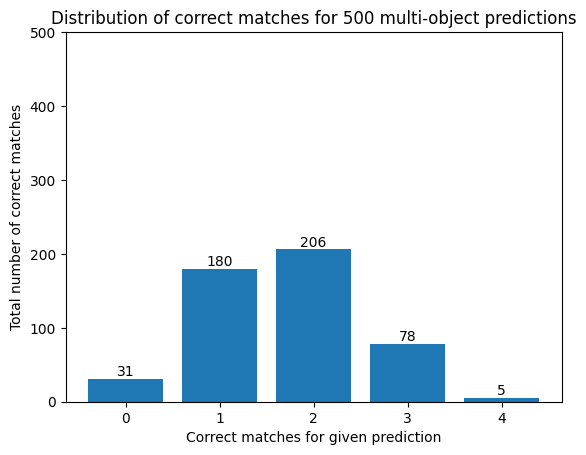

In [44]:
plot_correct_total(acc_eval,acc_eval)

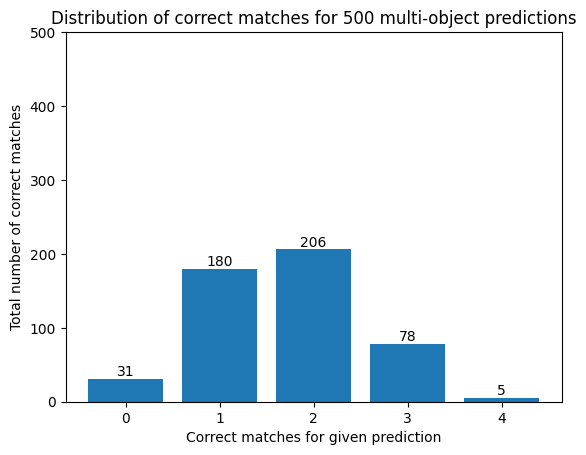

In [45]:
figure=plot_correct_total(acc_eval['Num_matches'],acc_eval,save=False,file_dest='corr_matches_500')

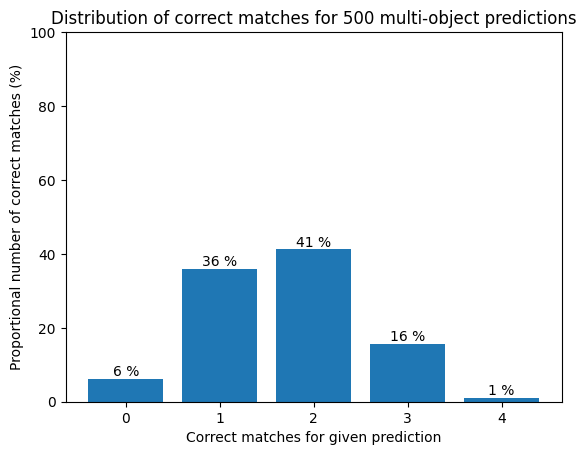

In [46]:
plot_correct_prop(acc_eval['Num_matches'],acc_eval,save=False,file_dest='prop_corr_matches_500')

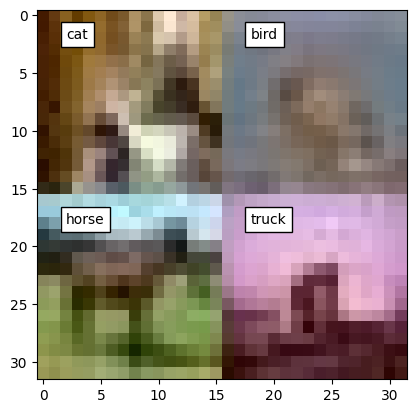

In [47]:
ax1=pic_label_show(image=files[0],labels=labels[0],save=False,file_dest='SampleImage_actual')

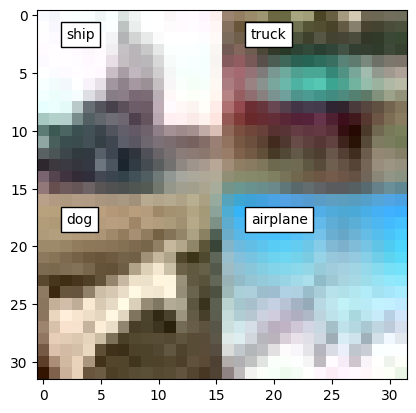

In [48]:
ax1=pic_label_show(image=files[1],labels=labels[1],save=False,file_dest='SampleImage_actual')

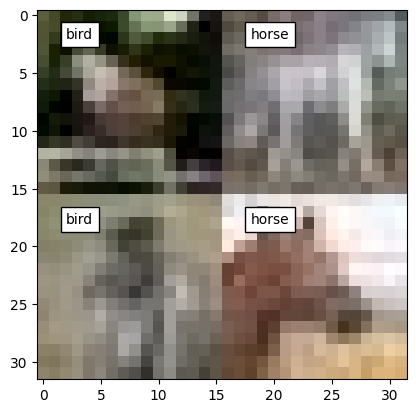

In [49]:
ax1=pic_label_show(image=files[2],labels=labels[2],save=False,file_dest='SampleImage_actual')

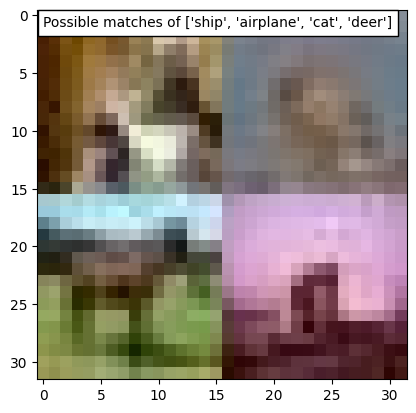

In [50]:
ax2=pic_label_show(image=files[0],labels=top_4_preds[0],predictions=True,save=False,file_dest='Sample_image_preds')

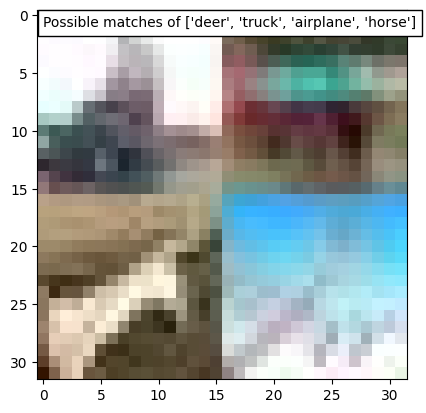

In [51]:
ax2=pic_label_show(image=files[1],labels=top_4_preds[1],predictions=True,save=False,file_dest='Sample_image_preds')

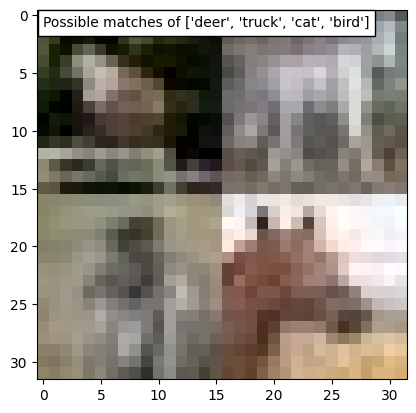

In [52]:
ax2=pic_label_show(image=files[2],labels=top_4_preds[2],predictions=True,save=False,file_dest='Sample_image_preds')

**This section calculates the precision, recall, false omision rate and markedness for the data set**

In [53]:
#Formulas

#Precision (PPV): TP / (TP + FP)
#Recall (TPR, Sensitivity): TP / (TP + FN)
#Negative Predictive Value (NPV): TN / (TN + FN)
#False Omission Rate (FOR): 1 − NPV = FN / (FN + TN)
#Markedness (MK): PPV + NPV − 1


In [54]:
from collections import Counter
from typing import List, Tuple

def per_image_tp_fp_fn_multiset(correct: List[Tuple[int, ...]], pred: List[Tuple[int, ...]]):
    per_image = []
    total_tp = total_pred_pos = total_true_pos = 0
    for i, (c, p) in enumerate(zip(correct, pred)):
        c_cnt, p_cnt = Counter(c), Counter(p)
        # TP is sum over labels of min(count_true, count_pred)
        tp = sum(min(c_cnt[l], p_cnt[l]) for l in set(c_cnt) | set(p_cnt))
        pred_pos = sum(p_cnt.values())
        fp = pred_pos - tp
        fn = sum(c_cnt.values()) - tp
        tn = len(c) - sum(c_cnt.values())
        precision = tp / pred_pos if pred_pos > 0 else 0.0
        recall = tp / sum(c_cnt.values()) if sum(c_cnt.values()) > 0 else 0.0
        NPV = tn / (tn + fn) if tn + fn > 0 else 0.0
        FOR = 1 - NPV
        markedness = precision + NPV - 1

        per_image.append({
            "image": i,
            "true_labels_multiset": c_cnt,
            "pred_labels_multiset": p_cnt,
            "TP": tp,
            "FP": fp,
            "FN": fn,
            "precision": precision,
            "recall": recall,
            "false_omission_rate": FOR,
            "markedness": markedness,

        })
        total_tp += tp
        total_pred_pos += pred_pos
        total_true_pos += sum(c_cnt.values())

    micro_precision = total_tp / total_pred_pos if total_pred_pos else 0.0
    micro_recall    = total_tp / total_true_pos if total_true_pos else 0.0

    return per_image, {
        "total_TP": total_tp,
        "micro_precision": micro_precision,
        "micro_recall": micro_recall,
        "total_pred_pos": total_pred_pos,
        "total_true_pos": total_true_pos,
    }

per_img_ms, summary_ms = per_image_tp_fp_fn_multiset(labels, top_4_preds)
for row in per_img_ms:
    print(row)
print("\nSummary (multiset):", summary_ms)


{'image': 0, 'true_labels_multiset': Counter({3: 1, 2: 1, 7: 1, 9: 1}), 'pred_labels_multiset': Counter({8: 1, 0: 1, 3: 1, 4: 1}), 'TP': 1, 'FP': 3, 'FN': 3, 'precision': 0.25, 'recall': 0.25, 'false_omission_rate': 1.0, 'markedness': -0.75}
{'image': 1, 'true_labels_multiset': Counter({8: 1, 9: 1, 5: 1, 0: 1}), 'pred_labels_multiset': Counter({4: 1, 9: 1, 0: 1, 7: 1}), 'TP': 2, 'FP': 2, 'FN': 2, 'precision': 0.5, 'recall': 0.5, 'false_omission_rate': 1.0, 'markedness': -0.5}
{'image': 2, 'true_labels_multiset': Counter({2: 2, 7: 2}), 'pred_labels_multiset': Counter({4: 1, 9: 1, 3: 1, 2: 1}), 'TP': 1, 'FP': 3, 'FN': 3, 'precision': 0.25, 'recall': 0.25, 'false_omission_rate': 1.0, 'markedness': -0.75}
{'image': 3, 'true_labels_multiset': Counter({6: 2, 0: 1, 7: 1}), 'pred_labels_multiset': Counter({4: 1, 8: 1, 0: 1, 9: 1}), 'TP': 1, 'FP': 3, 'FN': 3, 'precision': 0.25, 'recall': 0.25, 'false_omission_rate': 1.0, 'markedness': -0.75}
{'image': 4, 'true_labels_multiset': Counter({9: 1, 8

In [55]:
import numpy as np

def to_presence_matrix(bags, num_classes=10):
    Y = np.zeros((len(bags), num_classes), dtype=int)
    for i, bag in enumerate(bags):
        for l in set(bag):  # presence, not multiplicity
            if 0 <= l < num_classes:
                Y[i, l] = 1
    return Y

def micro_metrics_presence_with_negatives(correct, pred, num_classes=10):
    Y_true = to_presence_matrix(correct, num_classes)
    Y_pred = to_presence_matrix(pred, num_classes)
    TP = np.logical_and(Y_true == 1, Y_pred == 1).sum()
    FP = np.logical_and(Y_true == 0, Y_pred == 1).sum()
    FN = np.logical_and(Y_true == 1, Y_pred == 0).sum()
    TN = np.logical_and(Y_true == 0, Y_pred == 0).sum()

    precision = round(float(TP / (TP + FP)) if (TP + FP) else 0.0, 3)
    recall    = round(float(TP / (TP + FN)) if (TP + FN) else 0.0, 3)
    npv       = round(float(TN / (TN + FN)) if (TN + FN) else 0.0, 3)
    forate    = round(float(1 - npv), 3)
    markedness = round(float(precision + npv - 1), 3)
    return {
        "TP": int(TP), "FP": int(FP), "FN": int(FN), "TN": int(TN),
        "precision": precision, "recall": recall,
        "NPV": npv, "FOR": forate, "markedness": markedness
    }

In [62]:
# 1) Multiset (duplicates matter) TP/FP/FN + P/R/F1
per_img_rows, multiset_summary = per_image_tp_fp_fn_multiset(labels, top_95_cumulative_preds)
print("Multiset summary:", multiset_summary)

# 2A) Presence-based TN / NPV / FOR / Markedness (ignores multiplicity for TN)
presence_metrics = micro_metrics_presence_with_negatives(labels, top_95_cumulative_preds, num_classes=10)
print("Presence-based FOR/Markedness:", presence_metrics)

# 2B) Capacity-based TN / NPV / FOR / Markedness (multiplicity-aware with caps)
# capacity_metrics = multiset_metrics_with_capacity_TN(labels, top_4_preds, num_classes=10)
# print("Capacity-based FOR/Markedness:", capacity_metrics)


Multiset summary: {'total_TP': 1488, 'micro_precision': 0.36623184838789075, 'micro_recall': 0.744, 'total_pred_pos': 4063, 'total_true_pos': 2000}
Presence-based FOR/Markedness: {'TP': 1488, 'FP': 2575, 'FN': 234, 'TN': 703, 'precision': 0.366, 'recall': 0.864, 'NPV': 0.75, 'FOR': 0.25, 'markedness': 0.116}
